# Pythonを高速化するCythonを試してみよう

CythonはPython likeなコードをC/C++に変換、ネイティブコンパイルして高速動作するコンパイラです。  
このノートではこのCythonのいくつかの違う設定をした関数と、pure Pythonで実装した関数との速度比較を行います。

In [1]:
%load_ext Cython

## フィボナッチ数列

pure python

In [2]:
def fib_python(n):
    a, b = 0, 1
    for i in range(n):
        a, b = a + b, a
    return a

cython（特に型アノテーションをつけていない状態）

In [3]:
%%cython
def fib_cython(n):
    a, b = 0, 1
    for i in range(n):
        a, b = a + b, a
    return a

cython (引数にだけ型アノテーションをつけた状態）

In [4]:
%%cython
def fib_typed_cython(int n):
    a, b = 0, 1
    for i in range(n):
        a, b = a + b, a
    return a

cython （関数内で使われている変数にも全て型アノテーションをつけた状態）

In [5]:
%%cython
def fib_all_typed_cython(int n):
    cdef int a,b,i
    
    a, b = 0, 1
    for i in range(n):
        a, b = a + b, a
    return a

In [6]:
%timeit fib_python(5000)
%timeit fib_cython(5000)
%timeit fib_typed_cython(5000)
%timeit fib_all_typed_cython(5000)

664 µs ± 85.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
415 µs ± 19.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
346 µs ± 5.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.01 µs ± 235 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<IPython.core.display.Javascript object>


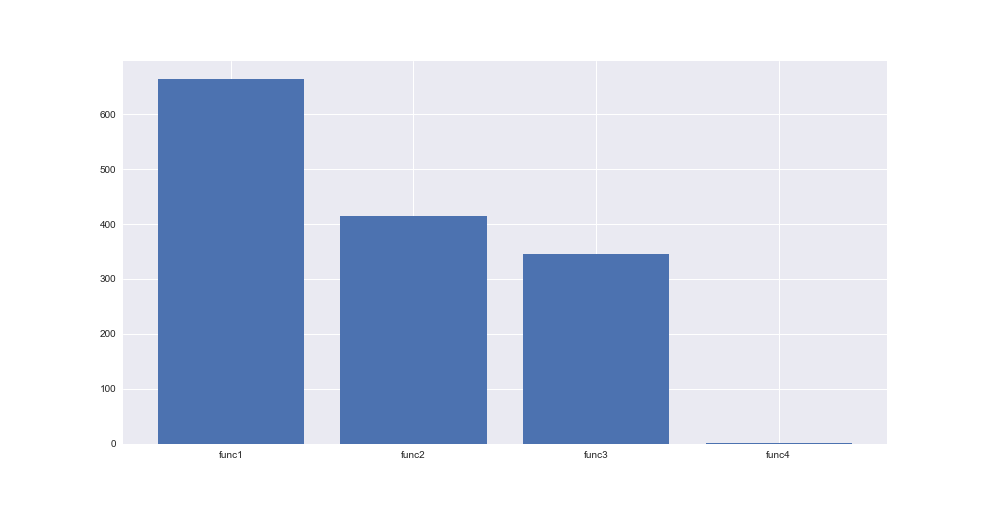

<Container object of 4 artists>

In [19]:
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set()
plt.bar(["func1","func2","func3","func4"],[664,415,346,2.01])

型付けをたくさん行った方が断然速くなる事がわかります。  
特に最後の関数は桁違いの速度が出ています。

ですが引数のみに型アノテーションをつけた状態でも、素のPythonよりはかなり速いですし、cdefを使った型付けを大変だと思う人もいるかも知れません。  
Cythonらしい書き方をしていくと、Pythonらしさが無くなっていく感じがあります。  
書きやすさと速度がトレードオフになる感じですね。  

## ユークリッドの互除法（再帰関数版）
最大公約数を求めるアルゴリズムです。



In [7]:
def gcd_python(x, y):
    if y == 0:
        return x
    else:
        return gcd_python(y, x % y)

In [8]:
%%cython

def gcd_cython(x, y):
    if y == 0:
        return x
    else:
        return gcd_cython(y, x % y)

In [9]:
%%cython

def gcd_typed_cython(int x, int y):
    if y == 0:
        return x
    else:
        return gcd_typed_cython(y, x % y)

In [10]:
%timeit gcd_python(10000,325)
%timeit gcd_cython(10000,325)
%timeit gcd_typed_cython(10000,325)

785 ns ± 154 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
445 ns ± 27.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
396 ns ± 38.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<IPython.core.display.Javascript object>


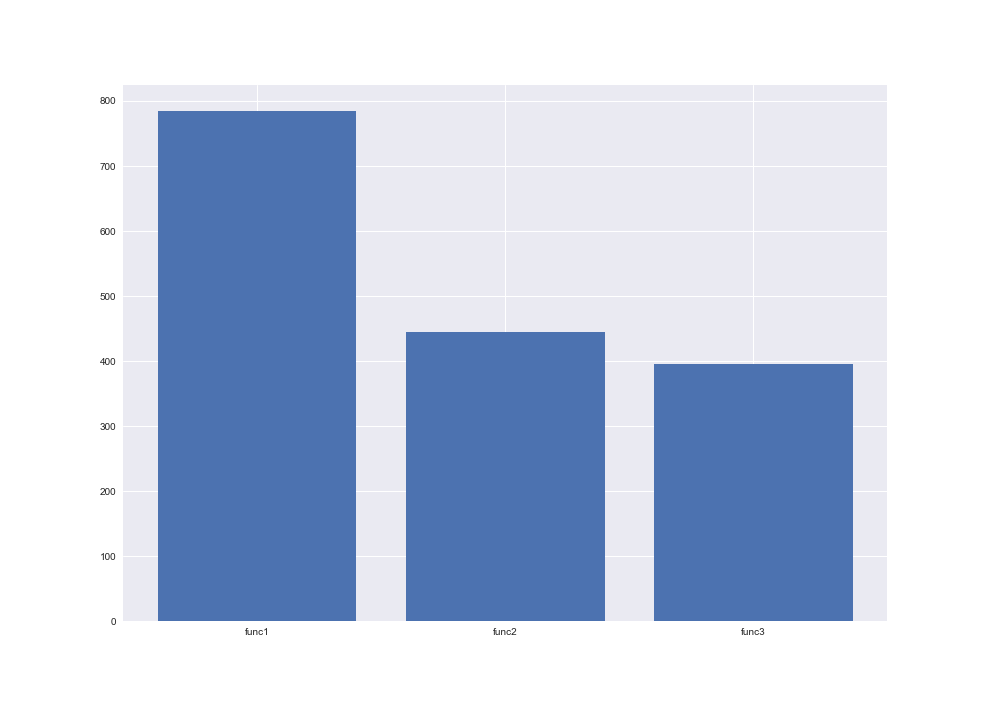

<Container object of 3 artists>

In [20]:
plt.bar(["func1","func2","func3"],[785,445,396])

こちらも順当に高速化できています。  
ただしここまで試して、再帰関数と普通のループだとどちらが速いのか気になりました。

普通のwhile文で書き直したバージョンも試してみます。

## ユークリッドの互除法（普通のwhile版）

In [11]:
def gcd_python2(x,y):
    while y!=0:
        x, y = y, x% y
    return x

In [12]:
%%cython
def gcd_cython2(x,y):
    while y!=0:
        x, y = y, x% y
    return x

In [13]:
%%cython
def gcd_typed_cython2(int x,int y):
    while y!=0:
        x, y = y, x% y
    return x

In [14]:
%timeit gcd_python2(10000,325)
%timeit gcd_cython2(10000,325)
%timeit gcd_typed_cython2(10000,325)

340 ns ± 7.31 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
221 ns ± 20.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
161 ns ± 33.8 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


<IPython.core.display.Javascript object>


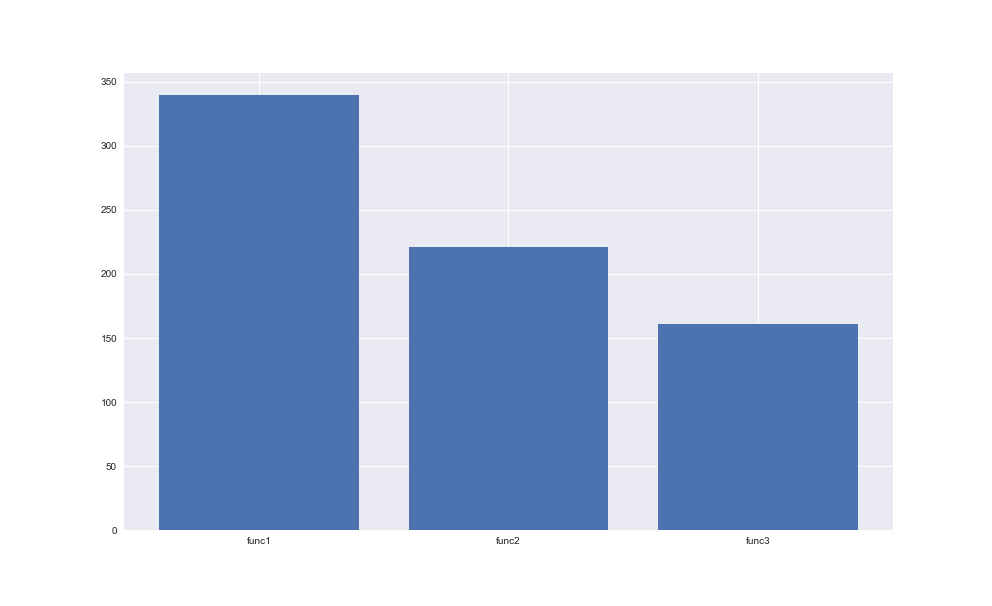

<Container object of 3 artists>

In [21]:
plt.bar(["func1","func2","func3"],[340,221,161])

順当に高速化できています。  
pure pythonの時点で再帰関数版よりも2倍速いです。  
cython版は、１番最適化を行ったものが１番伸び率が大きいですね。  

再帰関数は書きやすいですが、Python/Cythonで速度を気にする場合はやめたほうが良いかも知れませんね。